In [1]:
import torch
from torch import nn
from  torchvision import datasets, models, transforms

from sklearn.decomposition import PCA, KernelPCA
import numpy as np

In [2]:
# models
alex_model = models.alexnet(weights='IMAGENET1K_V1')
alex_model_random = models.alexnet()
vgg_model = models.vgg19(weights='IMAGENET1K_V1')
vgg_model_random = models.vgg19()
resnet_model = models.resnet18(weights='IMAGENET1K_V1')
resnet_model_random = models.resnet18()

In [3]:
alex_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
def plot_all_pcas(pcas):
    import matplotlib.pyplot as plt
    ncols = max([len(pcas[k]) for k in pcas])
    fig, axes = plt.subplots(figsize=(5*ncols, 3*len(pcas)), nrows=len(pcas), ncols=ncols)
    fig.tight_layout()
    for i, k in enumerate(pcas):
        for j, kk in enumerate(pcas[k]):
            pca = pcas[k][kk]
            ax = axes[i, j] if ncols > 1 else axes[i]
            ax.plot(pca.singular_values_)
            ax.set_title(kk)
            print(kk, ":", max(pca.explained_variance_ratio_), sum(pca.explained_variance_ratio_[:5]), max(pca.singular_values_), min(pca.singular_values_))
    plt.show()
    plt.close()

def layer_pca(layer, pcas, label):
    weights = np.array([np.array(torch.flatten(layer.weight[i])) for i in range(layer.weight.shape[0])])
    #pca_weights = PCA().fit(weights)
    weights_cov = np.matmul(weights, weights.T)
    pca = PCA().fit(weights_cov)
    pcas[f"{label} {weights.shape}"] = pca
    return pca
            
def get_layer_names(layer):
    name = ""
    if type(layer) == nn.Sequential:
        name = "Sequential"
    elif type(layer) == models.resnet.BasicBlock:
        name = "BasicBlock"
    elif type(layer) == nn.Conv2d:
        name = "Conv2d"
    elif type(layer) == nn.BatchNorm2d:
        name = "BatchNorm2d"
    elif type(layer) == nn.Linear:
        name = "Linear"
    return name
    
def module_pca(module, pcas, plabel=""):
    slayers = list(module.children())
    for i, slayer in enumerate(slayers):        
        slayer_key = " ".join([plabel, f"{get_layer_names(slayer)}{i}"])
        #print(slayer_key)
        if type(slayer) in [nn.Sequential, models.resnet.BasicBlock]:
            module_pca(slayer, pcas, slayer_key)
        else:
            if not hasattr(slayer, 'weight'):
                continue
            if slayer_key not in pcas:
                pcas[slayer_key] = {}
            layer_pca(slayer, pcas[slayer_key], slayer_key)
            
def model_pca(model):
    #print(model)
    pcas = {}
    print("Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue")
    with torch.no_grad():
        module_pca(model, pcas)
        plot_all_pcas(pcas)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue
 Sequential0 Conv2d0 (64, 363) : 0.11376817 0.48434940725564957 21.08764 4.9117057e-06
 Sequential0 Conv2d3 (192, 1600) : 0.13448429 0.3884855732321739 28.9769 2.1364622e-07
 Sequential0 Conv2d6 (384, 1728) : 0.13347164 0.30689145252108574 25.016727 5.162694e-07
 Sequential0 Conv2d8 (256, 3456) : 0.13536237 0.3396342322230339 20.980549 5.0021526e-06
 Sequential0 Conv2d10 (256, 2304) : 0.14902914 0.3233223482966423 13.890342 5.705297e-07
 Sequential2 Linear1 (4096, 9216) : 0.03649262 0.1456320807337761 27.335175 7.3989796e-08
 Sequential2 Linear4 (4096, 4096) : 0.10734438 0.23039314709603786 37.43153 3.0913407e-07
 Sequential2 Linear6 (1000, 4096) : 0.26650873 0.5397428087890148 44.581966 2.0765866e-07


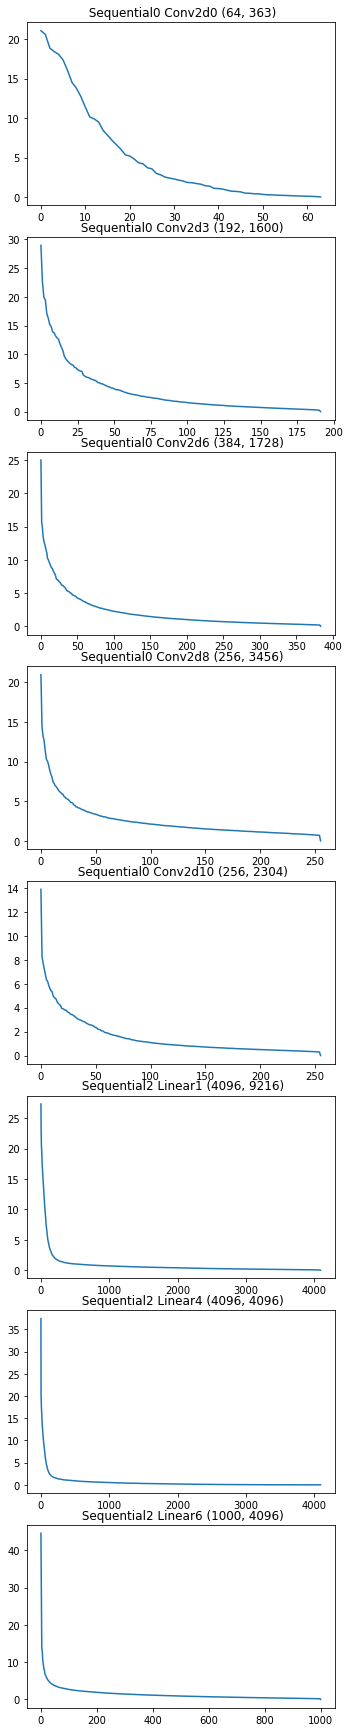

In [6]:
model_pca(alex_model)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue
 Sequential0 Conv2d0 (64, 363) : 0.050354753 0.218865767121315 0.641627 8.18311e-09
 Sequential0 Conv2d3 (192, 1600) : 0.014436921 0.06898985709995031 0.5840513 8.09869e-08
 Sequential0 Conv2d6 (384, 1728) : 0.009987673 0.04723120667040348 0.71974796 1.5845421e-08
 Sequential0 Conv2d8 (256, 3456) : 0.009334314 0.04523827135562897 0.5319339 5.6378504e-08
 Sequential0 Conv2d10 (256, 2304) : 0.010861269 0.0517028858885169 0.58462894 2.787882e-08
 Sequential2 Linear1 (4096, 9216) : 0.0013003021 0.006409908062778413 0.92455494 8.900453e-08
 Sequential2 Linear4 (4096, 4096) : 0.0019295531 0.009522327687591314 1.325264 3.1460434e-08
 Sequential2 Linear6 (1000, 4096) : 0.0039721592 0.019309436669573188 0.74098086 4.0049923e-09


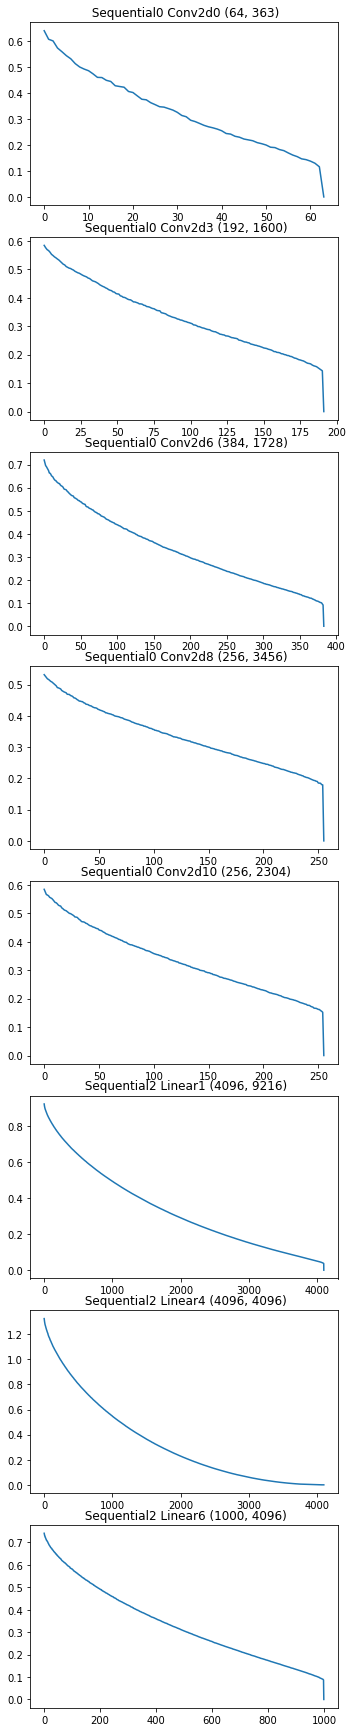

In [7]:
model_pca(alex_model_random)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue
 Sequential0 Conv2d0 (64, 27) : 0.33172098 0.940159447491169 23.413328 1.0755759e-06
 Sequential0 Conv2d2 (64, 576) : 0.22712721 0.6639093682169914 11.596113 9.935865e-07
 Sequential0 Conv2d5 (128, 576) : 0.12412361 0.4264070391654968 9.347425 4.4753193e-07
 Sequential0 Conv2d7 (128, 1152) : 0.092102386 0.32278216630220413 8.007583 3.7523897e-08
 Sequential0 Conv2d10 (256, 1152) : 0.074275635 0.26745395734906197 7.717496 1.4979285e-07
 Sequential0 Conv2d12 (256, 2304) : 0.059882607 0.2517098933458328 6.9685273 1.2025416e-06
 Sequential0 Conv2d14 (256, 2304) : 0.074608676 0.2876732684671879 7.6862183 6.413713e-07
 Sequential0 Conv2d16 (256, 2304) : 0.060560253 0.2252003327012062 6.6543627 1.9699696e-07
 Sequential0 Conv2d19 (512, 2304) : 0.04301065 0.17508313618600368 6.9518857 1.6086952e-07
 Sequential0 Conv2d21 (512, 4608) : 0.06266584 0.19151831045746803 8.63837 2.8283154e-07


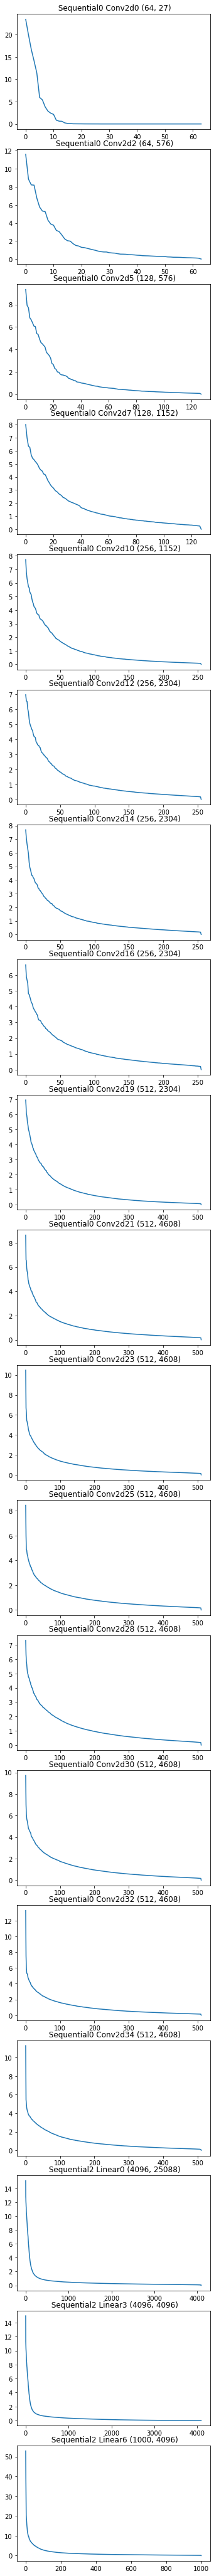

In [8]:
model_pca(vgg_model)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue
 Sequential0 Conv2d0 (64, 27) : 0.15942998 0.5673902928829193 0.5340089 1.2722672e-08
 Sequential0 Conv2d2 (64, 576) : 0.043440234 0.1943313367664814 3.4715962 2.7693534e-07
 Sequential0 Conv2d5 (128, 576) : 0.029109797 0.1315404698252678 2.0933094 7.4155224e-08
 Sequential0 Conv2d7 (128, 1152) : 0.021395387 0.100536173209548 3.4716556 7.639611e-08
 Sequential0 Conv2d10 (256, 1152) : 0.015310426 0.0712704611942172 2.190402 1.2055744e-07
 Sequential0 Conv2d12 (256, 2304) : 0.010734933 0.051595358178019524 3.4905381 1.2644576e-07
 Sequential0 Conv2d14 (256, 2304) : 0.010877829 0.05192943010479212 3.5044096 3.1374883e-09
 Sequential0 Conv2d16 (256, 2304) : 0.011213686 0.052802382968366146 3.5711427 2.1568692e-07
 Sequential0 Conv2d19 (512, 2304) : 0.0074089402 0.03582423087209463 2.1486208 2.6706311e-07
 Sequential0 Conv2d21 (512, 4608) : 0.005505122 0.026817046105861664 3.5357432 

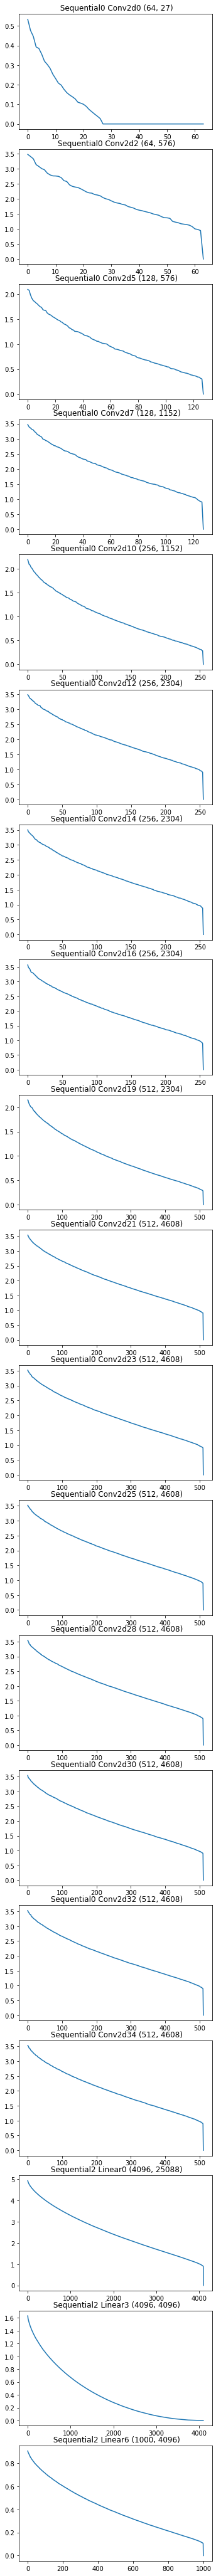

In [9]:
model_pca(vgg_model_random)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue
 Conv2d0 (64, 147) : 0.20023198 0.6584266051650047 17.03861 6.2917707e-07
 BatchNorm2d1 (64, 1) : 1.0 1.0000000000000653 2.2290401 1.4116288e-08
 Sequential4 BasicBlock0 Conv2d0 (64, 576) : 0.14257473 0.568009503185749 7.72374 7.9350383e-07
 Sequential4 BasicBlock0 BatchNorm2d1 (64, 1) : 1.0 1.0000000000001055 2.8653438 2.6274098e-08
 Sequential4 BasicBlock0 Conv2d3 (64, 576) : 0.12791613 0.4883881285786629 4.6602783 6.1449373e-07
 Sequential4 BasicBlock0 BatchNorm2d4 (64, 1) : 1.0 1.0000000000001061 2.752118 2.282763e-08
 Sequential4 BasicBlock1 Conv2d0 (64, 576) : 0.25236648 0.5603364370763302 8.603776 5.9445114e-08
 Sequential4 BasicBlock1 BatchNorm2d1 (64, 1) : 1.0 1.000000000000336 1.5063064 3.0168607e-08
 Sequential4 BasicBlock1 Conv2d3 (64, 576) : 0.10030638 0.3971675708889961 3.618109 1.7178562e-07
 Sequential4 BasicBlock1 BatchNorm2d4 (64, 1) : 1.0 1.0000000000000797 4.

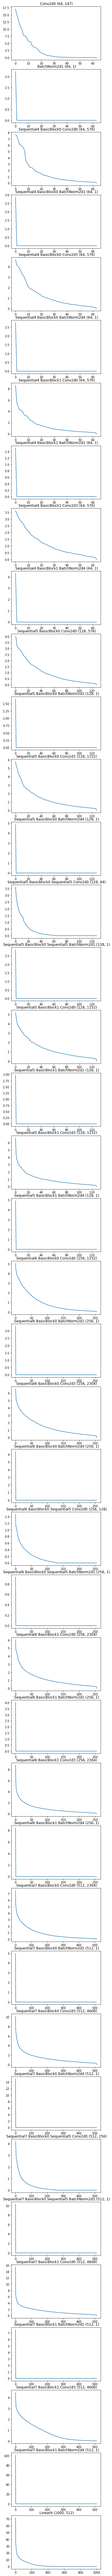

In [10]:
model_pca(resnet_model)

Layer: Max variance explained by single eigenvalue, Sum of top 5 eigenvalues, Max eigenvalue, Min eigenvalue


/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:527: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:527: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:527: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/hh/Documents/tutorials/ML_pytorch_exps/pytorch_exps_env/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:527: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/hh/Documents/tutorials/ML_pytorch_exps

 Conv2d0 (64, 147) : 0.07306543 0.3243190571665764 0.24287057 6.401753e-09
 BatchNorm2d1 (64, 1) : nan nan 0.0 0.0
 Sequential4 BasicBlock0 Conv2d0 (64, 576) : 0.044068377 0.185929574072361 3.537203 9.312501e-07
 Sequential4 BasicBlock0 BatchNorm2d1 (64, 1) : nan nan 0.0 0.0
 Sequential4 BasicBlock0 Conv2d3 (64, 576) : 0.047861915 0.1918470598757267 3.631993 6.0317643e-07
 Sequential4 BasicBlock0 BatchNorm2d4 (64, 1) : nan nan 0.0 0.0
 Sequential4 BasicBlock1 Conv2d0 (64, 576) : 0.04445558 0.19436269253492355 3.6030536 9.170942e-07
 Sequential4 BasicBlock1 BatchNorm2d1 (64, 1) : nan nan 0.0 0.0
 Sequential4 BasicBlock1 Conv2d3 (64, 576) : 0.046098754 0.1972314603626728 3.6082704 3.5669763e-07
 Sequential4 BasicBlock1 BatchNorm2d4 (64, 1) : nan nan 0.0 0.0
 Sequential5 BasicBlock0 Conv2d0 (128, 576) : 0.029797038 0.1329515017569065 2.1582305 4.8103385e-07
 Sequential5 BasicBlock0 BatchNorm2d1 (128, 1) : nan nan 0.0 0.0
 Sequential5 BasicBlock0 Conv2d3 (128, 1152) : 0.021690201 0.0985678

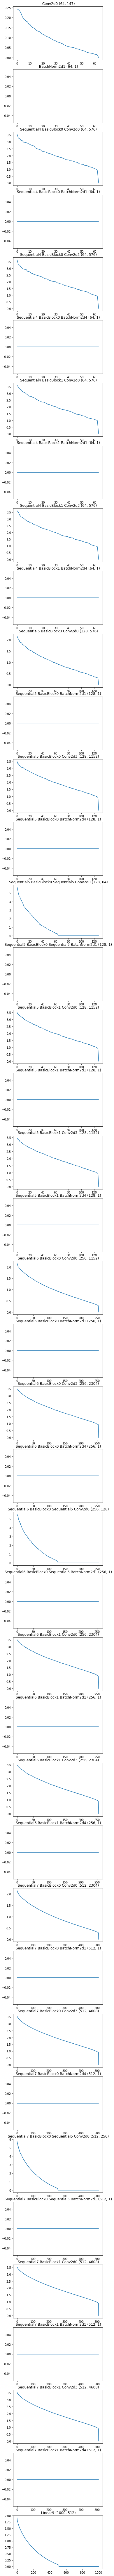

In [11]:
model_pca(resnet_model_random)

In [12]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 